In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
import warnings
np.random.seed(34)
warnings.filterwarnings('ignore')



**Define Columns**

In [2]:
index_names = ['engine', 'cycle']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
col_names = index_names + setting_names + sensor_names


df_train = pd.read_csv(('/kaggle/input/nasa-cmaps/CMaps/train_FD003.txt'), sep='\s+', header=None, names=col_names)
df_test = pd.read_csv(('/kaggle/input/nasa-cmaps/CMaps/test_FD003.txt'), sep='\s+', header=None, names=col_names)
df_test_RUL = pd.read_csv(('/kaggle/input/nasa-cmaps/CMaps/RUL_FD003.txt'), sep='\s+', header=None, names=['RUL'])

**Data Info**

In [3]:
df_train.head()

,engine,cycle,setting_1,setting_2,setting_3,(Fan inlet temperature) (◦R),(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(Fan inlet Pressure) (psia),...,(Ratio of fuel flow to Ps30) (pps/psia),(Corrected fan speed) (rpm),(Corrected core speed) (rpm),(Bypass Ratio),(Burner fuel-air ratio),(Bleed Enthalpy),(Required fan speed),(Required fan conversion speed),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow)
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583


In [4]:
print(df_train.head())
print(df_train.info())
print(df_train.isnull().sum())

   engine  cycle  setting_1  setting_2  setting_3  \
0       1      1    -0.0005     0.0004      100.0   
1       1      2     0.0008    -0.0003      100.0   
2       1      3    -0.0014    -0.0002      100.0   
3       1      4    -0.0020     0.0001      100.0   
4       1      5     0.0016     0.0000      100.0   

   (Fan inlet temperature) (◦R)  (LPC outlet temperature) (◦R)  \
0                        518.67                         642.36   
1                        518.67                         642.50   
2                        518.67                         642.18   
3                        518.67                         642.92   
4                        518.67                         641.68   

   (HPC outlet temperature) (◦R)  (LPT outlet temperature) (◦R)  \
0                        1583.23                        1396.84   
1                        1584.69                        1396.89   
2                        1582.35                        1405.61   
3               

**Engine Lifetime Distribution**

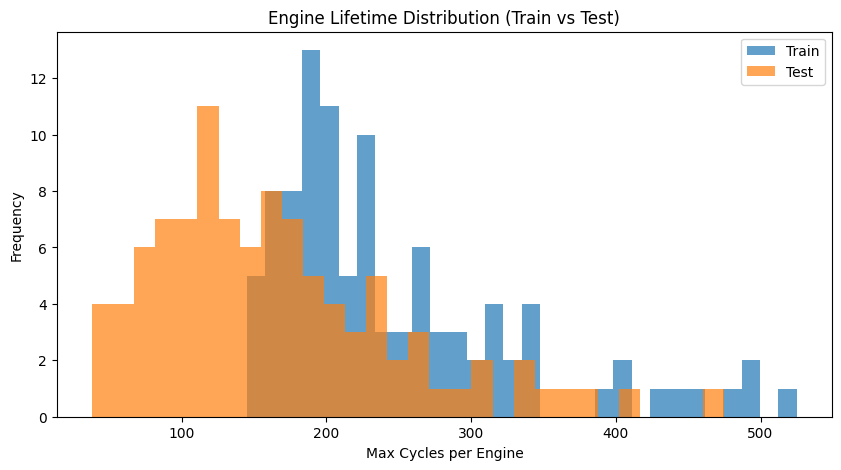

In [5]:
train_lifetimes = df_train.groupby("engine")["cycle"].max()
test_lifetimes = df_test.groupby("engine")["cycle"].max()

plt.figure(figsize=(10,5))
plt.hist(train_lifetimes, bins=30, alpha=0.7, label="Train")
plt.hist(test_lifetimes, bins=30, alpha=0.7, label="Test")
plt.xlabel("Max Cycles per Engine")
plt.ylabel("Frequency")
plt.title("Engine Lifetime Distribution (Train vs Test)")
plt.legend()
plt.show()


**Correlation Heatmap**

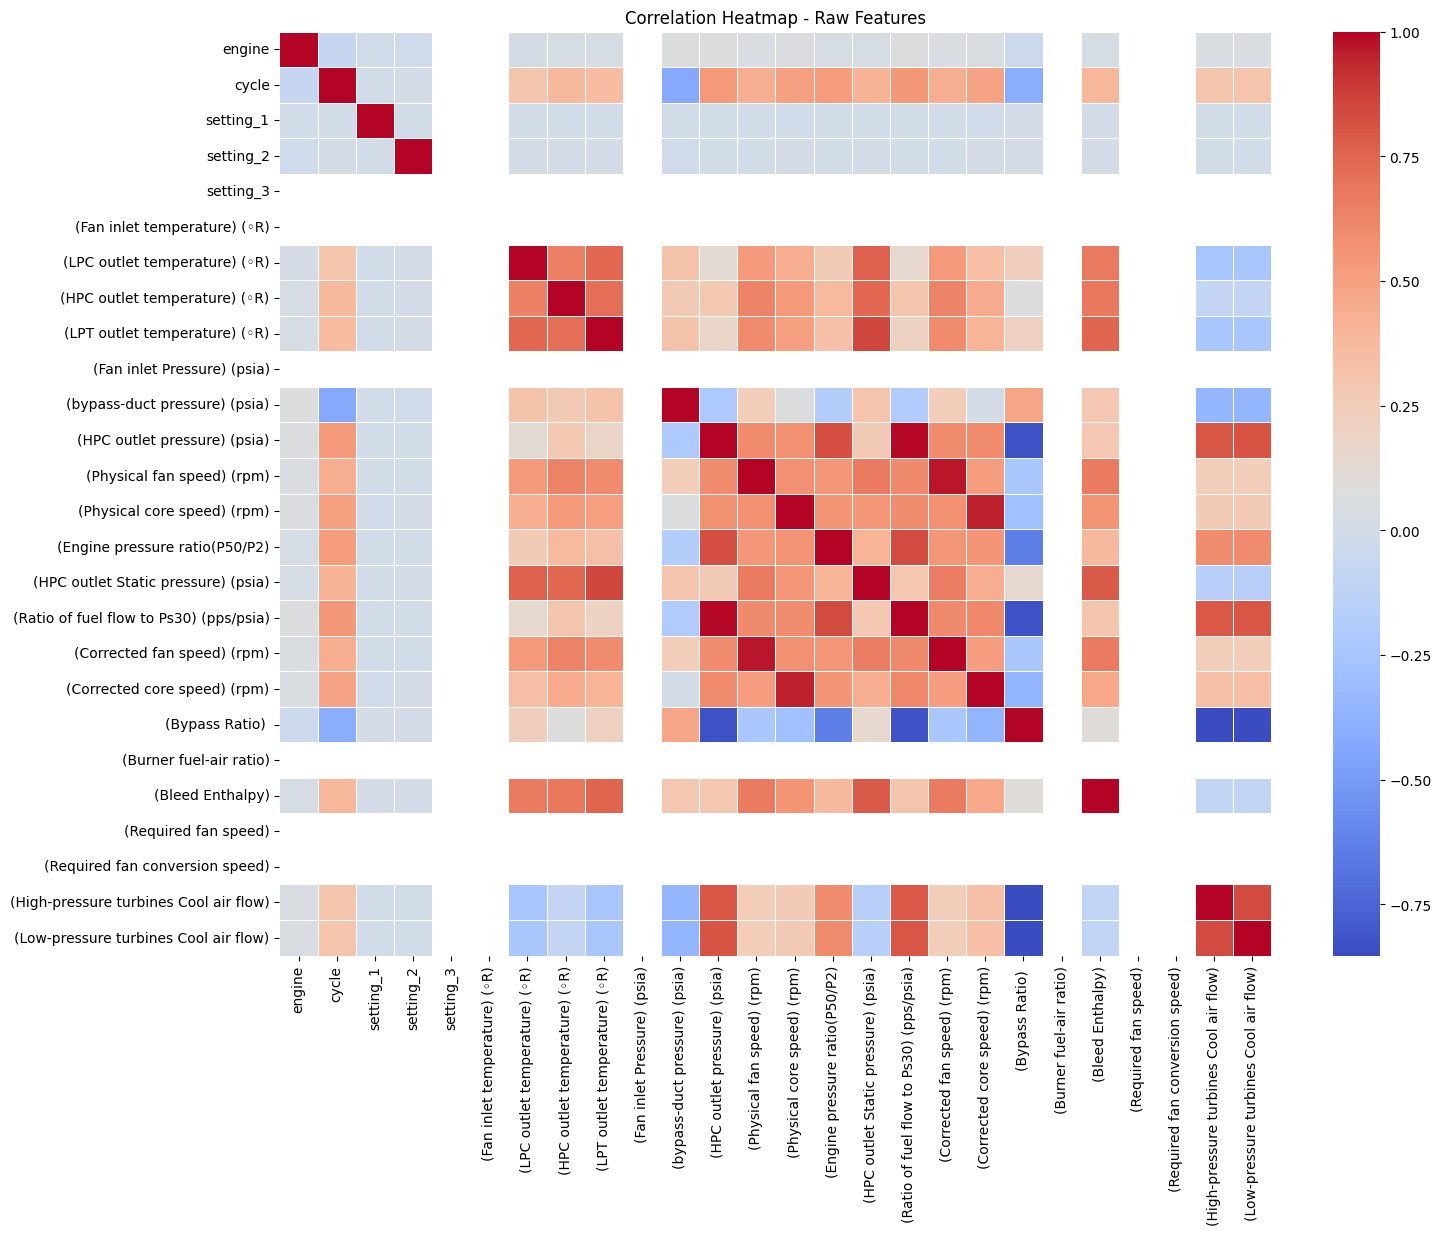

In [6]:
plt.figure(figsize=(16,12))
corr = df_train.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Correlation Heatmap - Raw Features")
plt.show()


**Sensor Distributions**

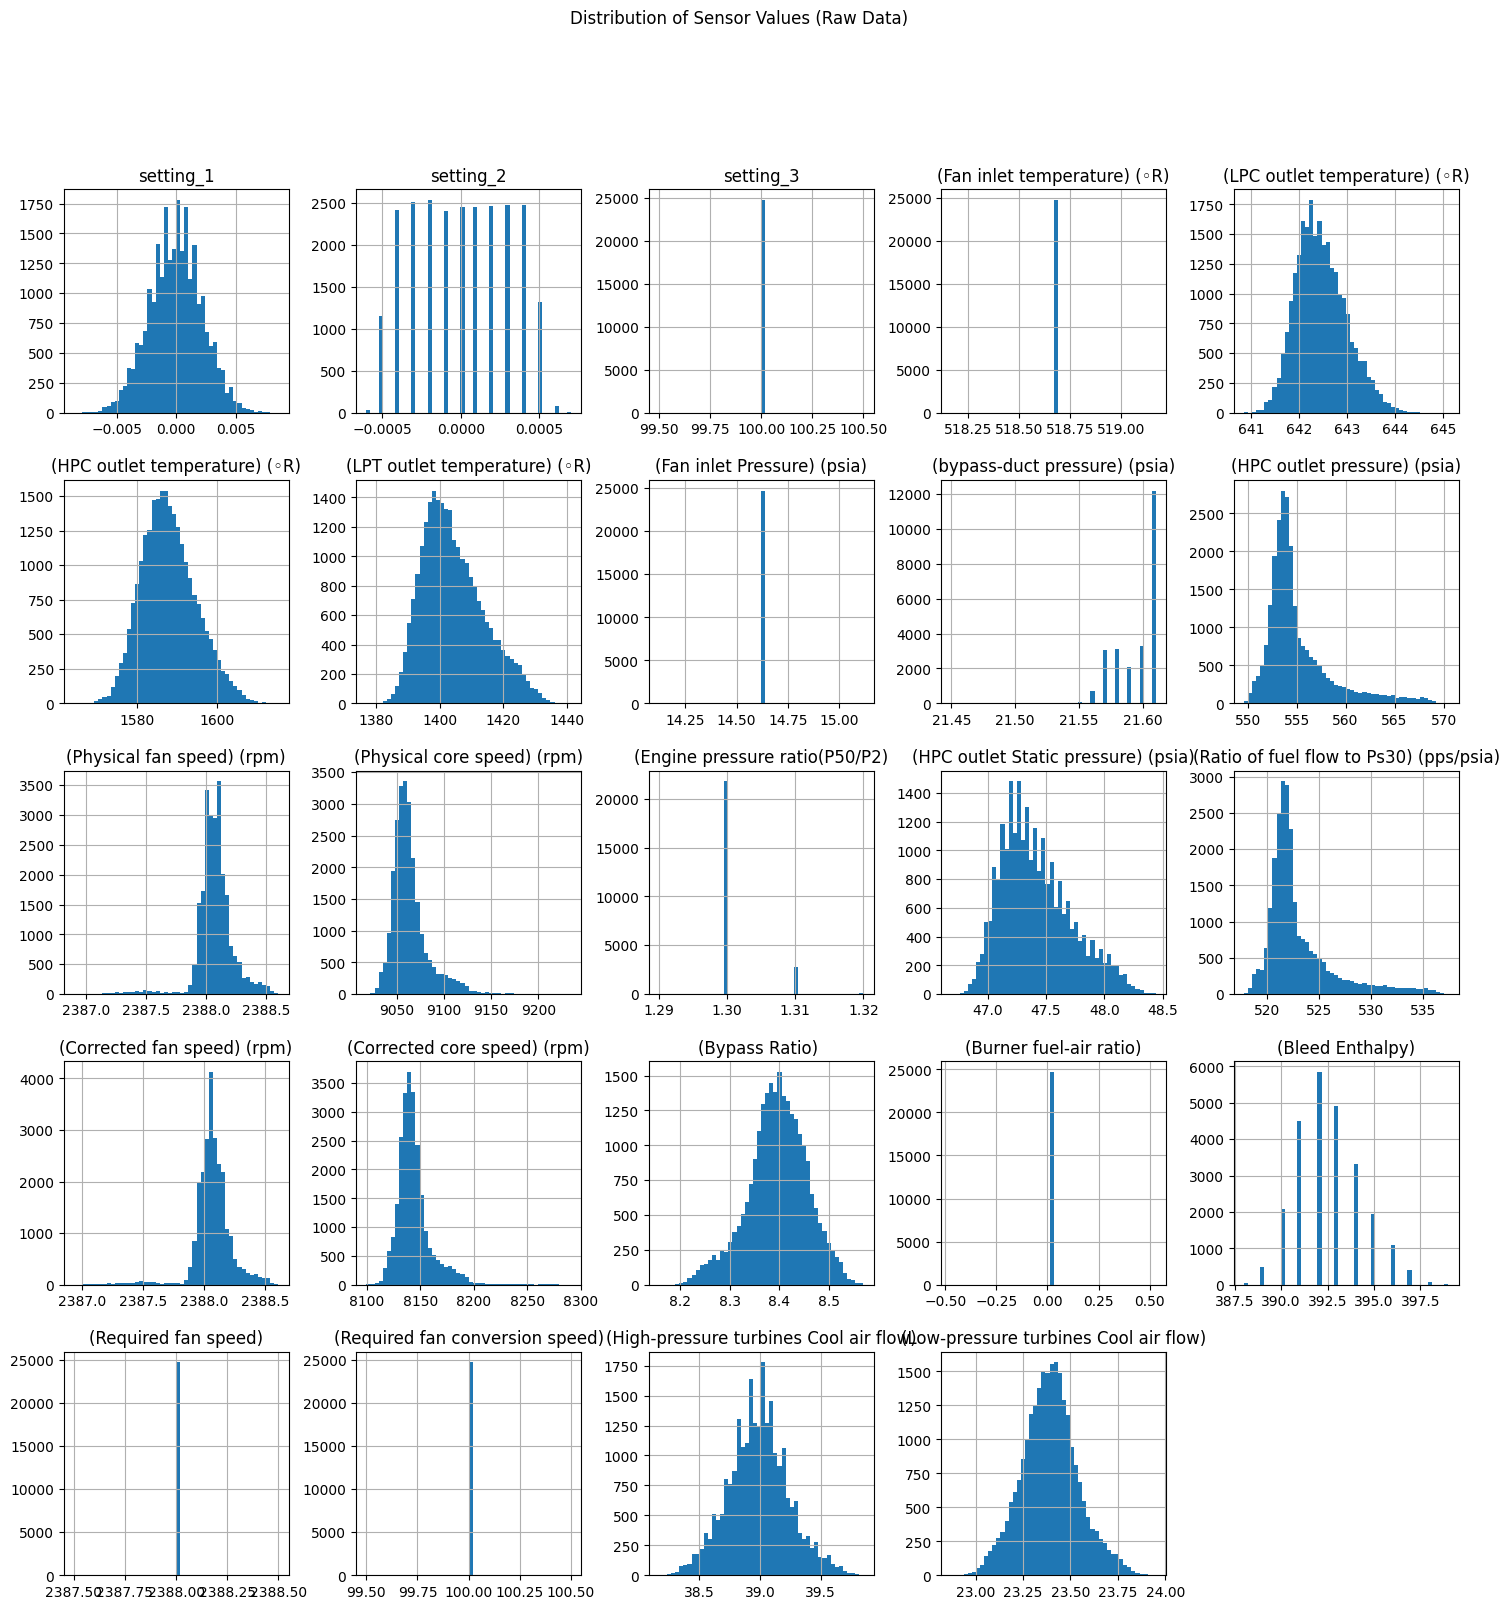

In [7]:
sensor_cols = [col for col in df_train.columns if col not in ['engine','cycle']]
df_train[sensor_cols].hist(figsize=(18,18), bins=50)
plt.suptitle("Distribution of Sensor Values (Raw Data)")
plt.show()


**Sensor Trends (Random Engines)**

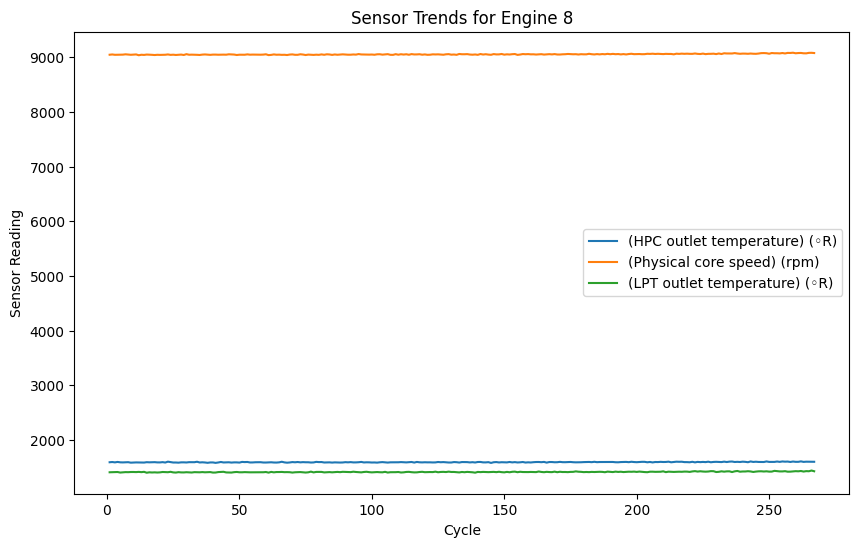

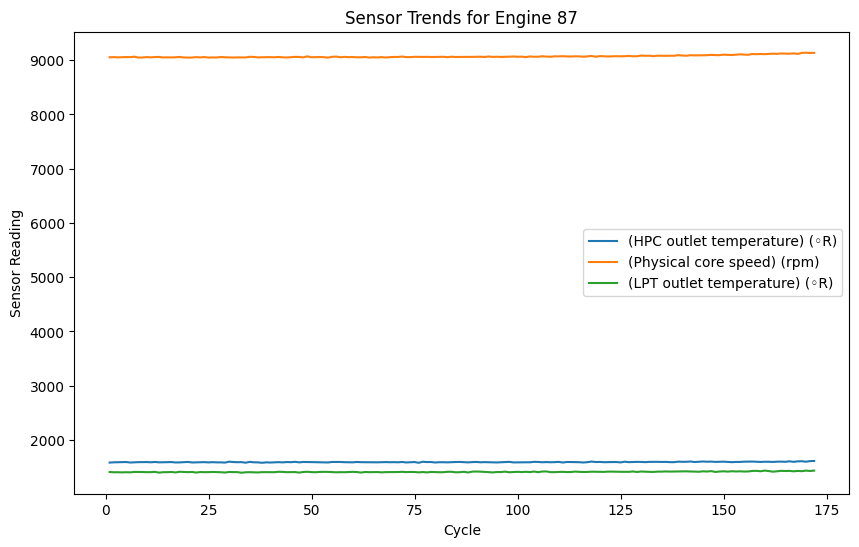

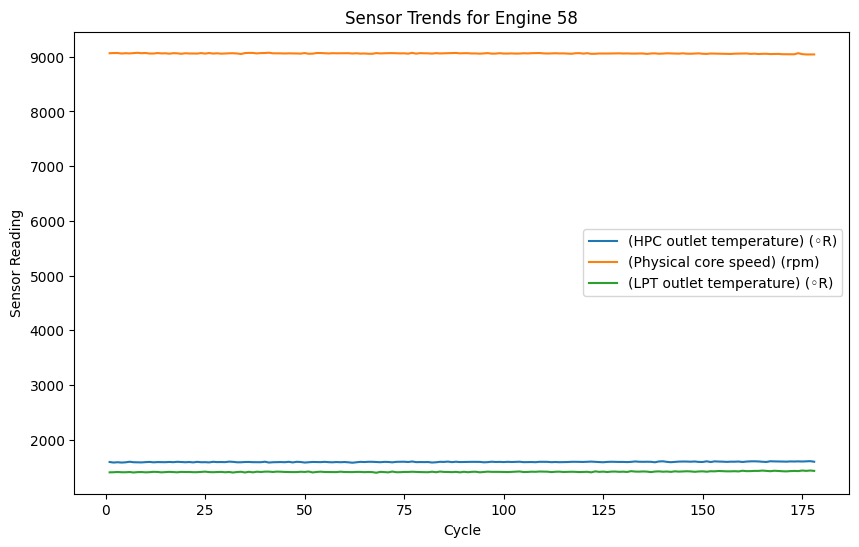

In [8]:
example_engines = random.sample(df_train['engine'].unique().tolist(), 3)
selected_sensors = [
    "(HPC outlet temperature) (◦R)",
    "(Physical core speed) (rpm)",
    "(LPT outlet temperature) (◦R)"
]

for eng in example_engines:
    subset = df_train[df_train['engine'] == eng]
    subset.plot(x="cycle", y=selected_sensors, figsize=(10,6))
    plt.title(f"Sensor Trends for Engine {eng}")
    plt.xlabel("Cycle")
    plt.ylabel("Sensor Reading")
    plt.show()


**Calculate RUL**

In [9]:
df_train["max_cycle"] = df_train.groupby("engine")["cycle"].transform("max")
df_train["RUL"] = df_train["max_cycle"] - df_train["cycle"]
df_train[df_train["engine"] == 1].tail()


,engine,cycle,setting_1,setting_2,setting_3,(Fan inlet temperature) (◦R),(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(Fan inlet Pressure) (psia),...,(Corrected core speed) (rpm),(Bypass Ratio),(Burner fuel-air ratio),(Bleed Enthalpy),(Required fan speed),(Required fan conversion speed),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow),max_cycle,RUL
254,1,255,0.0050,-0.0004,100.0,518.67,643.40,1599.87,1427.90,14.62,...,8143.28,8.5179,0.03,394,2388,100.0,38.39,23.0716,259,4
255,1,256,0.0019,0.0001,100.0,518.67,643.84,1599.31,1423.73,14.62,...,8151.14,8.5058,0.03,397,2388,100.0,38.46,23.0488,259,3
256,1,257,-0.0032,-0.0002,100.0,518.67,643.52,1601.37,1425.25,14.62,...,8149.36,8.5308,0.03,398,2388,100.0,38.36,23.1058,259,2
257,1,258,-0.0005,0.0001,100.0,518.67,643.66,1606.80,1431.35,14.62,...,8150.92,8.4947,0.03,396,2388,100.0,38.49,23.0658,259,1
258,1,259,0.0043,-0.0001,100.0,518.67,643.94,1599.54,1434.33,14.62,...,8149.15,8.5313,0.03,398,2388,100.0,38.35,23.0707,259,0


**RUL Visualization**

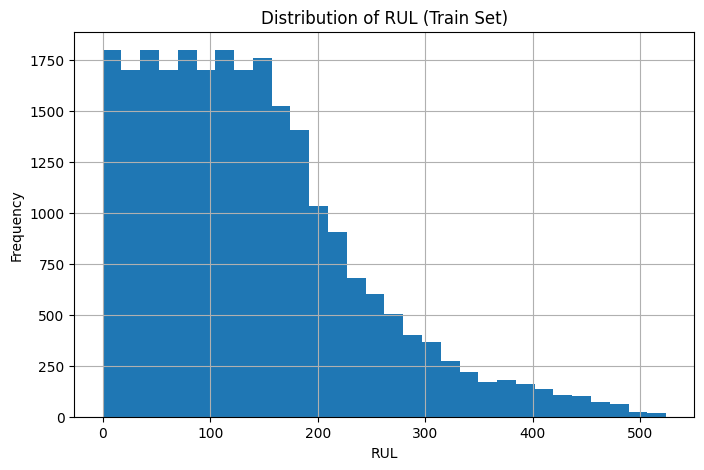

In [10]:
plt.figure(figsize=(8,5))
df_train["RUL"].hist(bins=30)
plt.title("Distribution of RUL (Train Set)")
plt.xlabel("RUL")
plt.ylabel("Frequency")
plt.show()


**Sensor vs RUL**

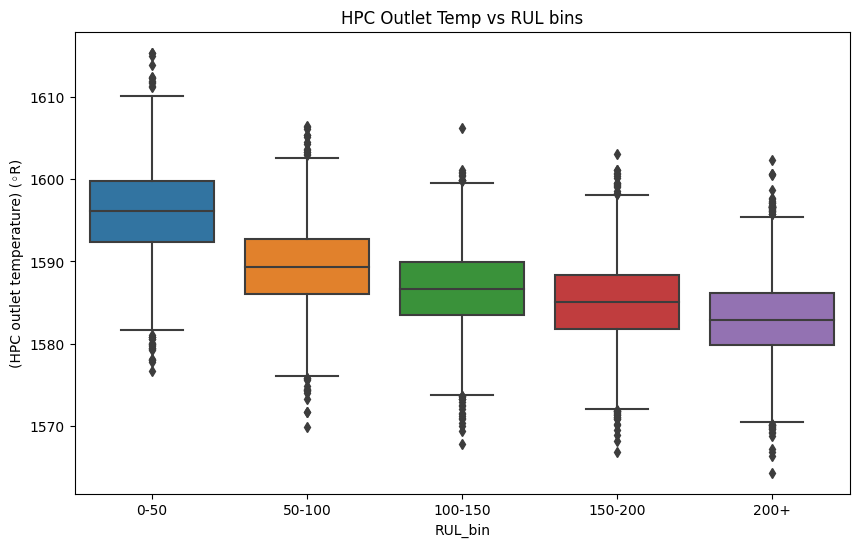

In [11]:
df_train["RUL_bin"] = pd.cut(df_train["RUL"], bins=[0,50,100,150,200,500], labels=["0-50","50-100","100-150","150-200","200+"])

plt.figure(figsize=(10,6))
sns.boxplot(x="RUL_bin", y="(HPC outlet temperature) (◦R)", data=df_train)
plt.title("HPC Outlet Temp vs RUL bins")
plt.show()


**Train vs Test Distribution)**

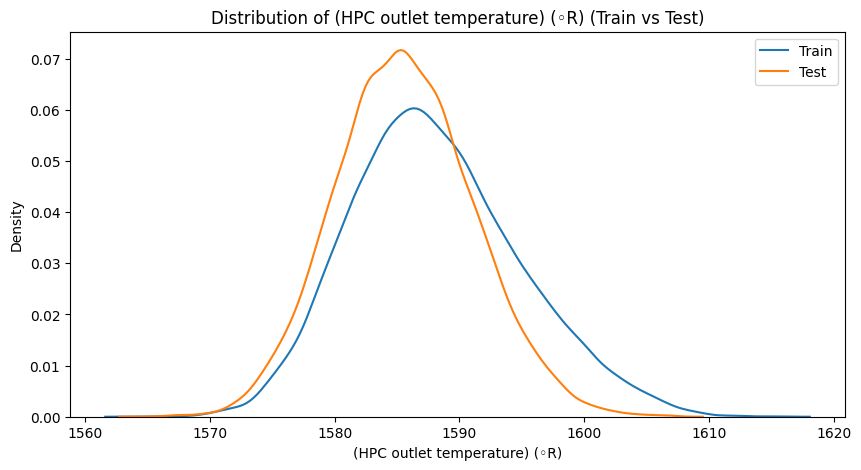

In [12]:
sensor = "(HPC outlet temperature) (◦R)"
plt.figure(figsize=(10,5))
sns.kdeplot(df_train[sensor], label="Train")
sns.kdeplot(df_test[sensor], label="Test")
plt.title(f"Distribution of {sensor} (Train vs Test)")
plt.legend()
plt.show()
